In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display

In [2]:
# заказы
orders = pd.read_csv('orders.csv',encoding="ISO-8859-1")

# покупатели 
customers = pd.read_csv('customers.csv')
orders.rename(columns={'customer_id': 'CustomerID', 'order_date':'InvoiceDate'}, inplace=True)

In [3]:
# Данные по покупателям и заказам 
df = pd.merge(orders, customers, left_on='CustomerID', right_on='id', suffixes=('', '_'))
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], infer_datetime_format=True)
df['OrderYear'] = df['InvoiceDate'].dt.strftime('%Y') 
df = df.drop(['id_'], axis=1)
df

,id,InvoiceDate,ship_mode,CustomerID,sales,name,segment,state,city,OrderYear
0,100006,2014-09-07,Standard,DK-13375,377.970,Dennis Kane,Consumer,Ohio,Marion,2014
1,131884,2015-12-06,Same Day,DK-13375,594.002,Dennis Kane,Consumer,Ohio,Marion,2015
2,145065,2015-12-12,First,DK-13375,32.308,Dennis Kane,Consumer,Ohio,Marion,2015
3,133046,2017-07-27,Second,DK-13375,297.990,Dennis Kane,Consumer,Ohio,Marion,2017
4,165099,2017-12-11,First,DK-13375,1.392,Dennis Kane,Consumer,Ohio,Marion,2017
...,...,...,...,...,...,...,...,...,...,...
5004,168193,2017-03-06,Second,RM-19750,98.350,Roland Murray,Consumer,New York,New York City,2017
5005,122140,2015-04-02,Standard,MO-17950,130.288,Michael Oakman,Consumer,Texas,Dallas,2015
5006,166233,2017-07-03,Standard,MO-17950,24.000,Michael Oakman,Consumer,Texas,Dallas,2017
5007,160150,2015-07-19,First,TS-21085,2.025,Thais Sissman,Consumer,Arizona,Phoenix,2015


In [4]:
# Оставим только покупателей с id и с указанием даты заказа
df=df[(df.CustomerID.notnull()) & (df.InvoiceDate.notnull())]

In [5]:
cohorts= df.groupby('CustomerID',as_index=False)['OrderYear'].min()
cohorts.rename(columns = {'OrderYear':'Cohort'},inplace=True)
df_merged= pd.merge(df,cohorts , how='left', on='CustomerID')


In [6]:
def cohort_period(df):
    """
    Creates column CohortPeriod
    """
    df['CohortPeriod'] = np.arange(len(df))
    return df

In [7]:
cohorts_group = df_merged.groupby(['Cohort', 'OrderYear']).agg({'CustomerID': pd.Series.nunique})
cohorts_group.rename(columns={'CustomerID': 'TotalUsers',
                        'InvoiceNo': 'TotalOrders'}, inplace=True)
cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['Cohort', 'CohortPeriod'], inplace=True) 
cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)


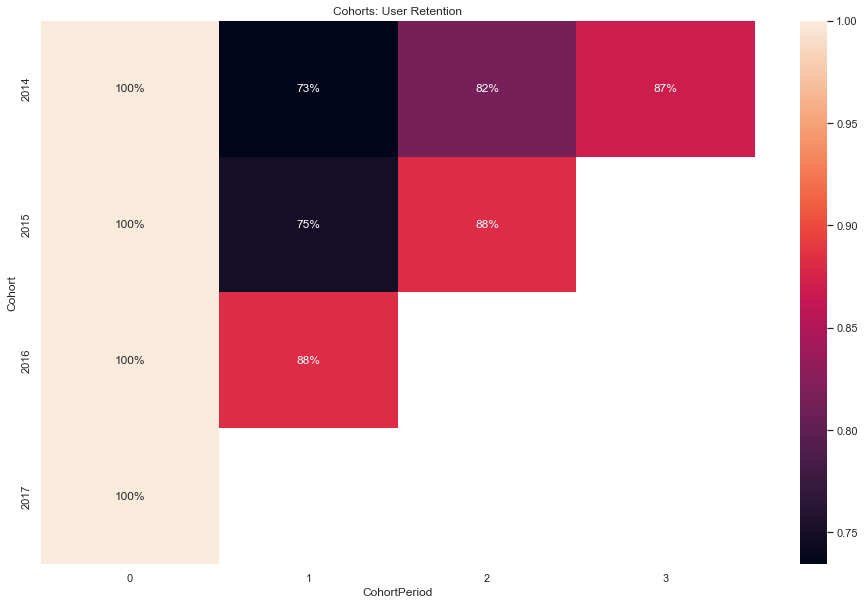

In [8]:
sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

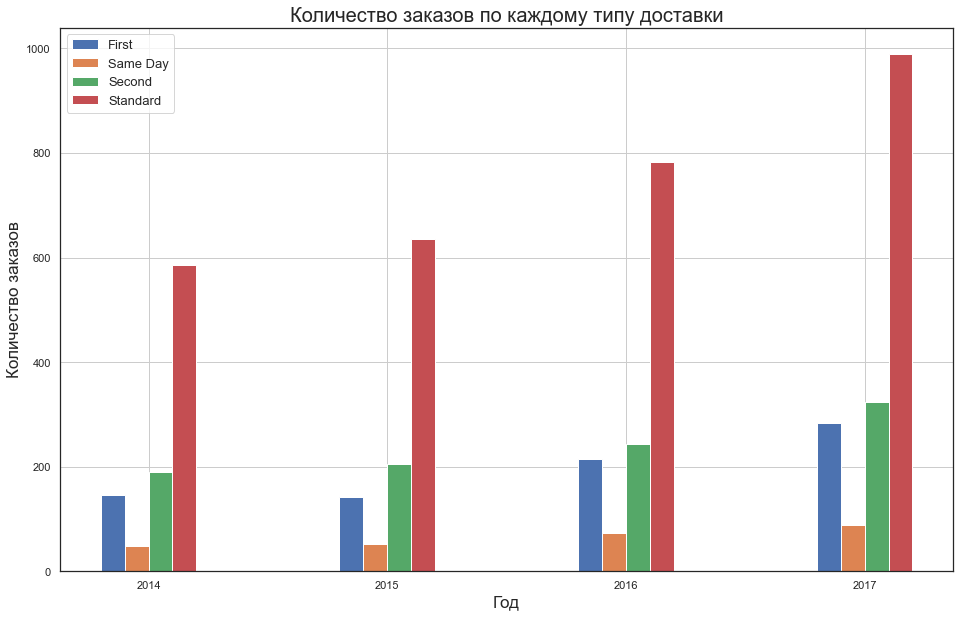

In [9]:
# Сгруппируем данные по годам и по типу доставки
group_data = df.groupby(['OrderYear', 'ship_mode']).agg({'sales':['count', 'mean', 'sum']}, axis=0).reset_index()
group_data.columns =['OrderYear','ship_mode', 'n_orders', 'mean_check', 'total_revenue']

# graph
plt.figure(figsize=(16, 10))
for i, ship_type in enumerate(['First', 'Same Day', 'Second', 'Standard']):
    ship_mode_data_frame = group_data[group_data.ship_mode == ship_type].reset_index(drop=True)
    plt.bar(ship_mode_data_frame.OrderYear.astype(int) - 0.15 + i * 0.1, ship_mode_data_frame.n_orders, label=ship_type, width=0.1)
    plt.legend(fontsize=13)
    plt.xticks([2014, 2015, 2016, 2017]);
plt.title('Количество заказов по каждому типу доставки', fontsize=20)
plt.xlabel('Год', fontsize=17)
plt.ylabel('Количество заказов', fontsize=17)
plt.grid()

Количество заказов растет в целом так и растет по отдельности по каждому типу доставки, что говорит о том что магазин развивается. 

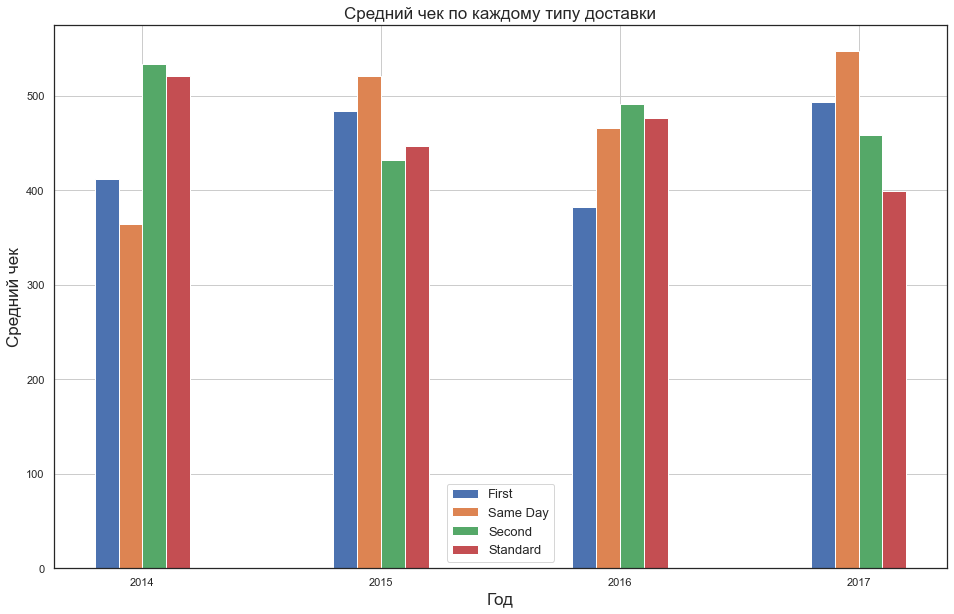

In [10]:
# График среднего чека по типу доставки
plt.figure(figsize=(16, 10))
for i, ship_type in enumerate(['First', 'Same Day', 'Second', 'Standard']):
    ship_mode_data_frame = group_data[group_data.ship_mode == ship_type].reset_index(drop=True)
    plt.bar(ship_mode_data_frame.OrderYear.astype(int) - 0.15 + i * 0.1, ship_mode_data_frame.mean_check, label=ship_type, width=0.1)
    plt.legend(fontsize=13)
    plt.xticks([2014, 2015, 2016, 2017]);
plt.title('Средний чек по каждому типу доставки', fontsize=17)
plt.xlabel('Год', fontsize=17)
plt.ylabel('Средний чек', fontsize=17)
plt.grid()

Нет зависимости от типа доставки и среднего чека по годам. То одна категория доставки имеет высокий средний чек, то другая. Нужно обсудить с другом

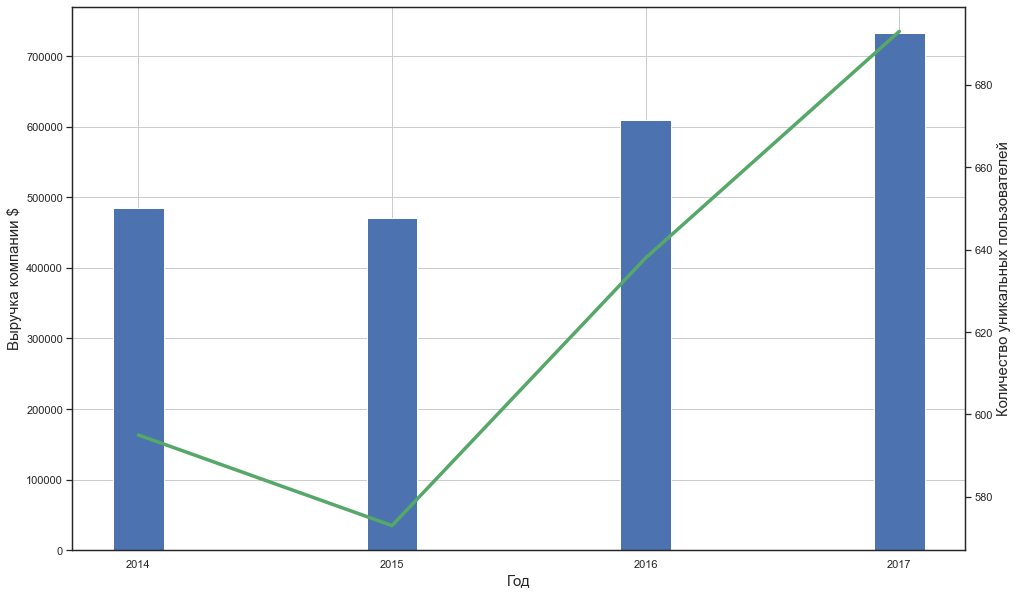

In [11]:
#Сгруппируем данные
grouped_by_year = df.groupby(['OrderYear']).agg({'sales':['count', 'mean', sum]}, axis=0).reset_index()
grouped_by_year.columns =['OrderYear', 'n_orders', 'mean_check', 'total_revenue']

#Нарисуем график уникальные пользователи выручка компании
fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()
ax1.bar([2014, 2015, 2016, 2017], (grouped_by_year.total_revenue), width=0.2)
ax2.plot([2014, 2015, 2016, 2017], [595, 573, 638, 693], linewidth=3.5, color='g')
ax1.set_ylabel('Выручка компании $', fontsize=15)
ax2.set_ylabel('Количество уникальных пользователей', fontsize=15)
ax1.set_xlabel('Год', fontsize=15)
ax1.set_xticks([2014, 2015, 2016, 2017])
ax1.grid()

Интернет магазин функционирует хорошо по сравнению с предыдушим годом:
- Около 88% (retention rate) пользователей делают повторные покупки по каждой когорте, что значительно лучше чем для 2016 года.
- Количество заказов по каждому типу доставки увеличивается
- Выручка компании и количество уникальных пользователей растет каждый год

Что вызывает вопросы и это нужно обсудить с руководителем интернет магазина.
- Особяй связи среднего чека покупки и типа доставки не было обнаружено по годам, что немного странно. Я бы ожидал, что доставки по типу same day должны иметь более низкий средний чек, чем по другим типам доставки так как по данному типу возможно будут заказы первой необходимости, те товары, что нужны в тот же день и скорее всего это незапланированная покупка.  

Единственно в 2015 году были проблемы в функционировнии магазина, но тут нужно более глубже раздираться почему так произошло.